## Benchmarking


I'm using this code to benchmark underlying function and my code generation tactics

will use a 2B1T + FWTD model and relise it at 20 m/s & 5 deg aoa

In [391]:
import sympy as sym
import sympy.physics.mechanics as me
from sympy.abc import t as time
import pandas as pd
import seaborn as sns

import numpy as np
from scipy.integrate import odeint,LSODA,BDF,solve_ivp
from scipy.linalg import eig
from scipy.optimize import minimize
import matplotlib.pyplot as plt

import sys, os

sys.path.insert(1, os.path.join(sys.path[0], '../..'))
import custom_plot_objects as cpo

import ModelFramework as mf
import ModelFramework.Elements as ele
import ModelFramework.ExternalForces as ef

me.mechanics_printing()

### Define the Model

#### Create Parameter instance

In [393]:
half = sym.Rational(1,2)

b_modes = 2
t_modes = 2
fwt_modes = 1
# lets go for B2T2 (so 5 DoF)
p = mf.ModelParameters.DynamicModel(b_modes + t_modes + fwt_modes)

## Create some global parameters
p.c = mf.ModelSymbol(value = 0.15,string = 'c') # chord of wing

p.m_0 = mf.ModelSymbol(value = 2,string = 'm_0') # total mass of the wing
p.s_t = mf.ModelSymbol(value = 1.345,string = 's_t') # chord of wing

p.ratio_fwt = mf.ModelSymbol(value = 0.345/1.345,string = 'sigma') # chord of wing

p.s_0 =  p.s_t*(1-p.ratio_fwt) # chord of wing

p.rho_0 =p.m_0/(p.s_0*p.c) # mass per unit area



# main Wing Structural Parameters
p.y_0 = sym.Symbol('y_0')
p.x_0 = sym.Symbol('x_0')

p.e_0 = mf.ModelSymbol(value = 0,string = 'e_0')
#p.x_f0 = mf.ModelSymbol(value = 0,string = 'xf_0')
p.x_f0 = sym.Rational(1,4)*p.c + p.e_0*p.c




p.s_1 = p.s_t*p.ratio_fwt # chord of fwt
p.m_1 = mf.ModelSymbol(value = 0.3,string = 'm_1')
p.I_xx_1 = sym.Rational(1,12)*p.m_1*p.s_1**2 # inertia of FWT (uniform bar)


## force soome frequencies
#p.f_0 = mf.ModelSymbol(value = 2,string = 'f_0') # first Bending mode frequency
#p.EI = (2*sym.pi*p.f_0/sym.Float(3.516))**2*(p.m_0+p.m_1)*(p.s_t)**3  # set EI to get desired frequency
p.EI = mf.ModelSymbol(value = 59.375,string = 'EI')

p.f_1 = mf.ModelSymbol(value = 4,string = 'f_1') # first Torsional Mode
#p.I_0 = p.rho_t*p.c*(half*p.rho_t-p.x_f0)
#p.GJ = (sym.Rational(4,3)*p.f_1*(p.s_0+p.s_1))**2*p.I_0
p.GJ = mf.ModelSymbol(value = 855.625,string = 'GJ') # GJ for main wing
p.GJ = mf.ModelSymbol(value = 85.625,string = 'GJ') # GJ for main wing

## FWTD Structural Parameters
p.y_1 = sym.Symbol('y_1')
p.x_1 = sym.Symbol('x_1')

p.e_1 = mf.ModelSymbol(value = 0,string = 'e_1') # e for the FWT
p.x_f1 = sym.Rational(1,4)*p.c + p.e_1*p.c

p.Lambda = mf.ModelSymbol(value = np.deg2rad(10),string = 'Lambda') # Flare Angle

## Aero Parameters
p.rho = mf.ModelSymbol(value = 1.225,string = 'rho') # density
p.V = mf.ModelSymbol(value = 10,string = 'V') # velocity
p.g  = mf.ModelSymbol(value = 9.81,string = 'g') # gravity
p.alpha_r = mf.ModelSymbol(value = np.deg2rad(3),string = 'alpha_r') # root AoA
p.M_thetadot = mf.ModelSymbol(value = -1.2,string = 'M_thetadot')

## Main Wing Specific
p.a_0 = mf.ModelSymbol(value = 2*np.pi,string = 'a_0') # C_L of main wing

## FWT Specific
p.a_1 = p.a_0 - p.a_0/p.s_1*p.y_1 # C_l of FWT 2pi at root zero at the end
p.alpha_1 = mf.ModelSymbol(value = 0,string = 'alpha_1') # FWT alpha
p.alphadot_1 = mf.ModelSymbol(value = 0,string = 'alphadot_1') # FWT alphadot

## Numeric Model Constants
p.fp = mf.ModelMatrix(value =[0]*p.qs*2,symbols=sym.symbols(f'qtilde:{p.qs*2}')) # The stationary point
p.eta = mf.ModelMatrix(value = [1]*b_modes+[1]*t_modes+[1]*fwt_modes,symbols=sym.symbols(f'eta:{p.qs}'))# [1]*b_modes+[1e3]*t_modes#[p.EI**2]*b_modes+[p.GJ**2]*t_modes

#### Create Transforms

In [394]:
#get shape functions for main wing
z_0,tau_0 = mf.ShapeFunctions_BN_TM(b_modes,t_modes,p.q[:-1],p.y_0,p.x_0,p.x_f0,0,factor=p.eta)

#define wrefernce frames
wing_root_frame = mf.HomogenousTransform().R_y(p.alpha_r)
wing_frame = wing_root_frame.Translate(p.x_0,p.y_0,z_0)
wing_flexural_frame = wing_frame.subs({p.x_0:p.x_f0})

fwt_root_frame = wing_frame.subs({p.y_0:p.s_0,p.x_0:p.x_f0}).Translate(-p.x_f0,0,0).R_x(-p.q[-1])
fwt_flexural_frame = fwt_root_frame.Translate(p.x_f1,p.y_1,0)
fwt_com_frame = fwt_root_frame.Translate(p.c/2,p.s_1/2,0)

#Create Elemnts
M_wing = ele.MassMatrix(p.rho_0)
M_fwt = ele.MassMatrix(p.m_1,I_xx = p.I_xx_1)

inner_wing_ele = ele.FlexiElement(wing_root_frame,M_wing,p.x_0,p.y_0,z_0,p.c,p.s_0,p.x_f0,p.EI,p.GJ,gravityPot=False)
fwt_ele = ele.RigidElement(fwt_com_frame,M_fwt,True)

# Create AeroForces
wing_AeroForces = ef.AeroForce.Generate(p,wing_flexural_frame,p.a_0,(p.y_0,0,p.s_0),
                               alphadot = tau_0 if isinstance(tau_0,int) else tau_0.diff(me.dynamicsymbols._t),
                               M_thetadot = p.M_thetadot,
                               e = p.e_0,
                               rootAlpha = p.alpha_r,
                               deltaAlpha = tau_0,
                               alpha_zero = 0)


tau_s0 = tau_0 if isinstance(tau_0,int) else tau_0.subs(p.y_0,p.s_0)
alpha_fwt = tau_s0 + p.alpha_1
alphadot_fwt = tau_s0 if isinstance(tau_0,int) else tau_s0.diff(me.dynamicsymbols._t) + p.alphadot_1

fwt_AeroForces = ef.AeroForce.Generate(p,fwt_flexural_frame,p.a_1,(p.y_1,0,p.s_1),
                               alphadot = alphadot_fwt,
                               M_thetadot = p.M_thetadot,
                               e = p.e_1,
                               rootAlpha = alpha_fwt,
                               deltaAlpha = 0,
                               alpha_zero = 0)

In [395]:
#Create Composite force
CompositeForce = ef.CompositeForce(p,[wing_AeroForces,fwt_AeroForces])
#CompositeForce = ef.CompositeForce(p,[wing_AeroForces,fwt_AeroForces,wing_GravityForces])
inner_wing_ele._gravityPotential = True
# Create the SYmbolic Model
sm = mf.SymbolicModel.FromElementsAndForces(p,[inner_wing_ele,fwt_ele],CompositeForce)

# Setup Numeric Model Parameters


In [396]:
tmax, dt = 5, 0.01

#set velocity and alpha_r funcs
def Vfunc(t,x):
    return 18

def arfunc(t,x):
    return np.deg2rad(5)
    #return np.deg2rad(5)+np.sin(2*np.pi*1*t)*np.deg2rad(5)
    
p.V.value = Vfunc
p.alpha_r.value = arfunc
    
## Get functions for Fwt AoA and its derivative
fwt_aoa = mf.GetAoA(p.alpha_r,0,p.Lambda.value,p.q[-1])
FwtAoA = sym.lambdify((p.alpha_r,p.x),fwt_aoa)
DotFwtAoA = sym.lambdify((p.alpha_r,p.x),fwt_aoa.diff(me.dynamicsymbols._t))

import types

p.alpha_1.value = fwt_aoa
p.alpha_1._dependent = True
p.alpha_1.GetSub = types.MethodType(lambda self,t,x: fwt_aoa , p.alpha_1)
p.alpha_1._GetValue = types.MethodType(lambda self,t,x : FwtAoA(arfunc(t,x),x) , p.alpha_1)

p.alphadot_1.value = fwt_aoa.diff(time)
p.alphadot_1._dependent = True
p.alphadot_1.GetSub = types.MethodType(lambda self,t,x: self.value , p.alphadot_1)
p.alphadot_1._GetValue = types.MethodType(lambda self,t,x : DotFwtAoA(arfunc(t,x),x), p.alphadot_1)



ts = np.arange(0, tmax+dt, dt)

constraints = [np.NaN]*p.qs*2
const_idx = np.isnan(constraints)

def objectiveDeriv(t,y):
    deriv = sm.deriv(t,y,p.GetNumericTuple(y,t))
    return tuple(np.where(const_idx,deriv,constraints))

## create masses 

In [397]:
y0 = [0]*p.qs*2
sm_mini = sm.subs(p,{p.alpha_1:p.alpha_1.value,p.alphadot_1:p.alphadot_1.value})
#sm_mini = sm_mini.subs(p,p.GetSubs(0,[0]*p.qs*2,ignore=[p.eta,p.EI,p.GJ,p.s_t,p.f_0,p.e_0,p.M_thetadot,p.V,p.alpha_1,p.alphadot_1,p.alpha_r]))

def objectiveDeriv(t,y):
    deriv = sm_mini.deriv(t,y,p.GetNumericTuple(y,t))
    return tuple(np.where(const_idx,deriv,constraints))

In [398]:
sm_mini.M

⎡                     4  4          4  3          4  2          4          4  
⎢                m₀⋅sₜ ⋅σ    4⋅m₀⋅sₜ ⋅σ    6⋅m₀⋅sₜ ⋅σ    4⋅m₀⋅sₜ ⋅σ   m₀⋅sₜ   
⎢                ───────── - ─────────── + ─────────── - ────────── + ────── +
⎢                      2            2             2            2          2   
⎢                  5⋅η₀         5⋅η₀          5⋅η₀         5⋅η₀       5⋅η₀    
⎢                                                                             
⎢       5  5          5  4          5  3          5  2          5           5 
⎢  m₀⋅sₜ ⋅σ    5⋅m₀⋅sₜ ⋅σ    5⋅m₀⋅sₜ ⋅σ    5⋅m₀⋅sₜ ⋅σ    5⋅m₀⋅sₜ ⋅σ    m₀⋅sₜ  
⎢- ───────── + ─────────── - ─────────── + ─────────── - ────────── + ─────── 
⎢   6⋅η₀⋅η₁      6⋅η₀⋅η₁       3⋅η₀⋅η₁       3⋅η₀⋅η₁      6⋅η₀⋅η₁     6⋅η₀⋅η₁ 
⎢                                                                             
⎢                                                                             
⎢                           3  3               3  2 

In [511]:
p.V.value = 30
p.GJ.value = 100
p.s_t.value = 1.345

p.e_0.value = 0.2
p.e_1.value = 0.2
p.m_0.value = 1.5
p.m_1.value = 0.25
p.alpha_r.value = np.deg2rad(10)

def objectiveDeriv(t,y):
    deriv = sm_mini.deriv(t,y,p.GetNumericTuple(y,t))
    return tuple(np.where(const_idx,deriv,constraints))

#set velocity and alpha_r funcs
def Vfunc(t,x):
    return 20+np.array(t)

p.V.value = Vfunc

y0 = p.fp.value
y0 = [0]*p.qs*2
yData = solve_ivp(objectiveDeriv,(0,15),y0)
#yData = solve_ivp(objectiveDeriv,(0,tmax),yi[:,-1])

func_alpha = alpha_fwt.subs(p.GetSubs(0,y0))

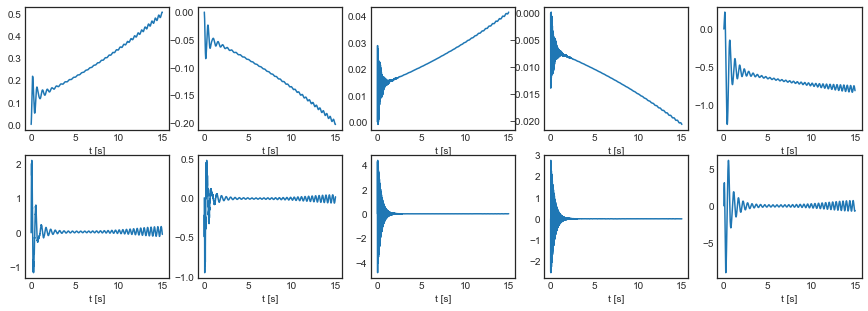

In [512]:
yi = yData.y
t = yData.t

plt.style.use('seaborn-white')

fig, axes = plt.subplots(2,int(len(yi)/2),figsize=(15,5))

for i in range(int(len(yi)/2)):
    # pos plot
    axes[0][i].plot(t,yi[i*2])
    axes[0][i].set_ylabel('')
    axes[0][i].set_xlabel('t [s]')
    #axes[0][i].set(xlim=(0,0.1))
    
    # vel plot
    axes[1][i].plot(t,yi[i*2+1])
    axes[1][i].set_ylabel('')
    axes[1][i].set_xlabel('t [s]')
    #axes[1][i].set(xlim=(0,0.1))

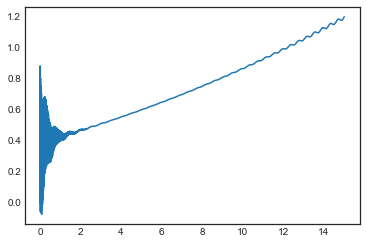

In [513]:
#alp = [sm_mini.ExtForces.forces[1].GetAlpha(p.GetNumericTuple(i,0),i,0,0) for i in yi.T]
#plt.plot(t,np.rad2deg(alp))

func_tau = sym.lambdify((p.x,),tau_s0.subs(p.GetSubs([0]*p.qs*2,0)))
twist = [func_tau(i) for i in yi.T]
plt.plot(t,np.rad2deg(twist))

## Create the linearised EoM about some Stationary point

In [403]:
ignores = [p.EI,p.V,p.GJ,p.s_t,p.e_0,p.e_1,p.m_0,p.m_1,p.alpha_r]
# sub in functions!
sm_subbed = sm.subs(p,{p.alpha_1:p.alpha_1.value,p.alphadot_1:p.alphadot_1.value})

# get the linearised sm
sm_lin = sm_subbed.subs(p,p.GetSubs(0,p.fp,ignore=ignores)).linearise(p)

# get eigen Matrices and turn into a function
K,M = sm_lin.eigenMatrices(p)

In [404]:
func = sym.lambdify((ignores + [p.fp]),(K,M),'numpy')

In [405]:
q = sym.Matrix(p.fp[::2])
qd = sym.Matrix(p.fp[1::2])
f = (sm_lin.f-sm_lin.ExtForces.Q())
f = (sm_lin.f-sm_lin.ExtForces.Q()).subs({p.x[i]:p.fp[i] for i in range(-1,-len(p.x)-1,-1)}).subs({i:0 for i in qd})

In [500]:
p.V.value = 20
p.GJ.value = 100
p.s_t.value = 1.345

p.e_0.value = 0.2
p.e_1.value = 0.2
p.m_0.value = 1.5
p.m_1.value = 0.25
p.alpha_r.value = np.deg2rad(10)

f_0 = 2
p.EI.value = (2*np.pi*f_0/3.516)**2*(p.m_0.value +p.m_1.value)*(p.s_t.value)**3/p.c.value
p.EI.value = 50
values = [i.value for i in ignores]
func_obj = sym.lambdify((q,p.V),(f.T*f).subs(p.GetSubs(0,q,ignore=[p.fp,p.V]))[0])

In [501]:
df = pd.DataFrame(columns=['v','aoa','q','Lambda'])
vs = np.linspace(0,80,161)
pLast = [0]*p.qs
pLast[-1] = np.pi/2
for v in vs:
    p.V.value = v 
    pLast = minimize(func_obj,pLast,method='Powell',args=(v)).x
    v0 = [0]*p.qs
    y0 = [j for i in range(len(pLast)) for j in [pLast[i],v0[i]]]
    df = df.append({'aoa' : np.rad2deg(p.alpha_r(0,y0)), 'v' : v,'q':y0,'Lambda':np.rad2deg(p.Lambda.value)} , ignore_index=True)
    pLast
data = df

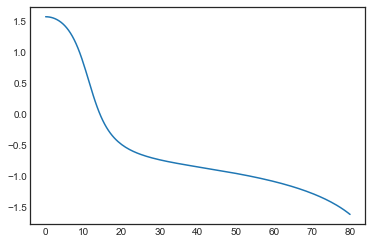

In [502]:
aoa = []
for i in data['q']:
    aoa.append(i[-2])
plt.plot(data['v'],aoa)

In [503]:
flutdfv2 = pd.DataFrame() 
for i in range(0,len(data)):  
    # get the fixed point
    #lp = [data['eta'].iloc[i],0,data['q1'].iloc[i],0]

    # get the jacobian evaluated at this point
    #j_lp = func(data['v'].iloc[i],np.deg2rad(data['Lambda'].iloc[i]),ratio,lp)
    # get eigen value information
    #jac_dat = dof2.ExtractEigenValueData(j_lp,sortby='Damping')
    p.V.value = data['v'].iloc[i]
    values = tuple([i.value for i in ignores])
    evals, evecs = eig(*func(*values,data['q'].iloc[i]))
    jac_dat = mf.ExtractEigenValueData(evals,evecs,sortby='Frequency')

    # populate test specific data   
    jac_dat['V'] = data['v'].iloc[i]
    #jac_dat['Mass Ratio'] = f'r = {ratio}'
    y = np.array(data['q'].iloc[i])
    for i in range(len(y)):
        jac_dat[f'q_{i}'] =y[i]
    jac_dat['Lambda'] = data['Lambda'].iloc[i]
    flutdfv2 = flutdfv2.append(jac_dat,sort=False)
        
flutdfv2 = flutdfv2.reset_index(drop=True) 

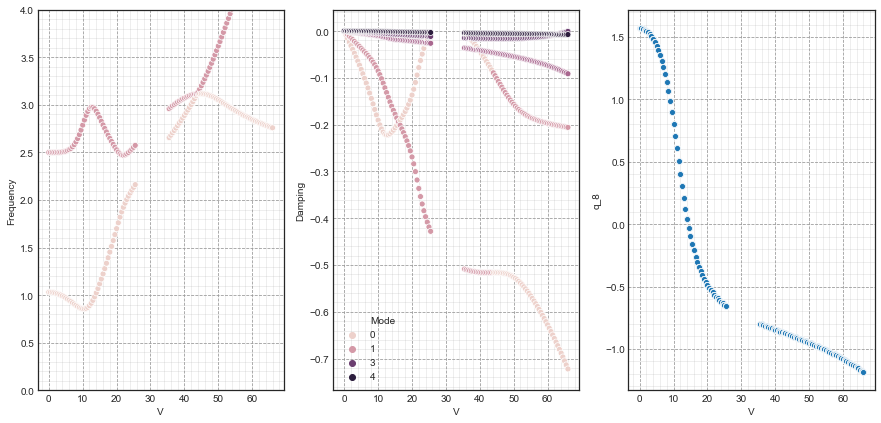

In [504]:
#data = flutdf[(flutdf['aoa']==5) & (flutdf['Damping']<0)]
#data = flutdfv2[(flutdfv2['Stable'])]
#data = flutdfv2[flutdfv2['Lambda']==10]
data = flutdfv2[flutdfv2['Stable']]
#data = flutdfv2
fig, axes = plt.subplots(1,3,figsize=(15,7))


sns.scatterplot(data=data,x='V',y='Frequency',hue='Mode',ax=axes[0],legend=False)
sns.scatterplot(data=data,x='V',y='Damping',hue='Mode',ax=axes[1])
sns.scatterplot(data=data,x='V',y=f'q_{p.qs*2-2}',ax=axes[2])

for i in [0,1,2]:
    #axes[i].set(xlim=(0,60))
    axes[i].grid(b=True, which='major', color='#999999', linestyle='--')
    axes[i].minorticks_on()
    axes[i].grid(b=True, which='minor', color='#999999', linestyle='-', alpha=0.2)
    #axes[i].set(xlim=(0,60))
#axes[0].set(ylim=(0.5,3))
axes[0].set(ylim=(0,4))

In [499]:
flutdfv2[flutdfv2['Stable']]['V'].max()